In [3]:
# face_detection_demo.ipynb
%pip install mediapipe opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Create output folder if it does not exist
os.makedirs("output", exist_ok=True)

# Global initializers
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [5]:
# Function to show an image using matplotlib
def show_image(image, title="Image"):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
# Function to resize an image while maintaining aspect ratio
def resize_image(image, width=800):
    h, w = image.shape[:2]
    height = int(h * (width / w))
    resized = cv2.resize(image, (width, height))
    return resized


In [7]:
# Function to save the output image
def save_output(image, filename="output.jpg", folder="output"):
    path = f"{folder}/{filename}"
    cv2.imwrite(path, image)
    print(f"✅ Image saved in: {path}")

In [8]:
# Function to detect faces and print detection scores

"""
    Detects faces in an image and returns the image with the detected faces and their IDs.

    Parameters:
    - image_path: string, path to the input image.

    Returns:
    - image: with the detected faces and their IDs drawn.
    - detections_data: list of tuples with information about the detections (bounding box, score).
"""

def detect_faces_with_ids(image_path):
    image = cv2.imread(image_path)
    image = resize_image(image)  # Resize the image for better visualization
    detections_data = []
    if image is None:
        raise FileNotFoundError(f"Unable to load image: {image_path}")
    
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = detector.process(rgb)

        if not results.detections:
            print("❌ No faces detected.")
            return image, []  # ← Here we return an empty list of detections
        
        h, w, _ = image.shape  # Height and width to convert relative bboxes

        for i, detection in enumerate(results.detections):
            bbox = detection.location_data.relative_bounding_box
            score = detection.score[0]

            x = int(bbox.xmin * w)
            y = int(bbox.ymin * h)

            print(f"[#{i+1}] Confidence: {score:.2f}, BBox: (x={bbox.xmin:.2f}, y={bbox.ymin:.2f}, w={bbox.width:.2f}, h={bbox.height:.2f})")
            mp_drawing.draw_detection(image, detection)
            
            # Draw ID as text
            cv2.putText(image, f"#{i+1}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.9, (0, 255, 0), 2, cv2.LINE_AA)
            
            detections_data.append((bbox, score))

    return image, detections_data  # ← Now we return image and detections


In [9]:
# Function to blur faces in an image
def blur_faces(image_path):
    image = cv2.imread(image_path)
    image = resize_image(image)  # Resize the image for better visualization
    if image is None:
        raise FileNotFoundError(f"Unable to load image: {image_path}")

    output = image.copy()
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = detector.process(rgb)

        if results.detections:
            h, w, _ = image.shape
            for i, detection in enumerate(results.detections):
                bbox = detection.location_data.relative_bounding_box
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = int((bbox.xmin + bbox.width) * w)
                y2 = int((bbox.ymin + bbox.height) * h)

                face_roi = output[y1:y2, x1:x2]
                face_blur = cv2.GaussianBlur(face_roi, (55, 55), 30)
                output[y1:y2, x1:x2] = face_blur
        else:
            print("⚠️ No faces were detected for defocusing.")
            return None

    return output

[#1] Confidence: 0.95, BBox: (x=0.69, y=0.15, w=0.11, h=0.17)
[#2] Confidence: 0.92, BBox: (x=0.48, y=0.24, w=0.10, h=0.16)
[#3] Confidence: 0.86, BBox: (x=0.31, y=0.27, w=0.10, h=0.15)
[#4] Confidence: 0.73, BBox: (x=0.11, y=0.20, w=0.09, h=0.14)
🔍 Detections found: 4


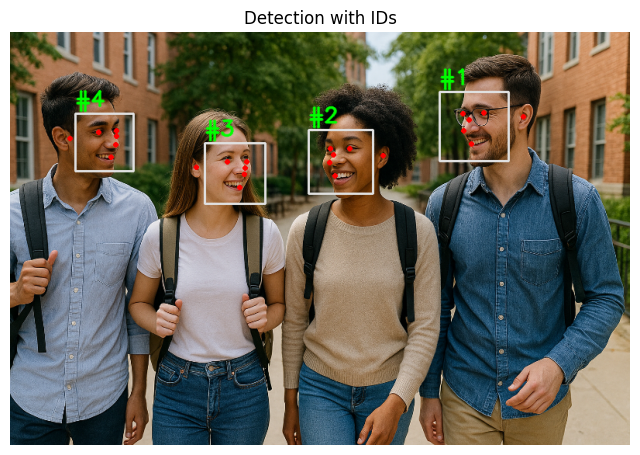

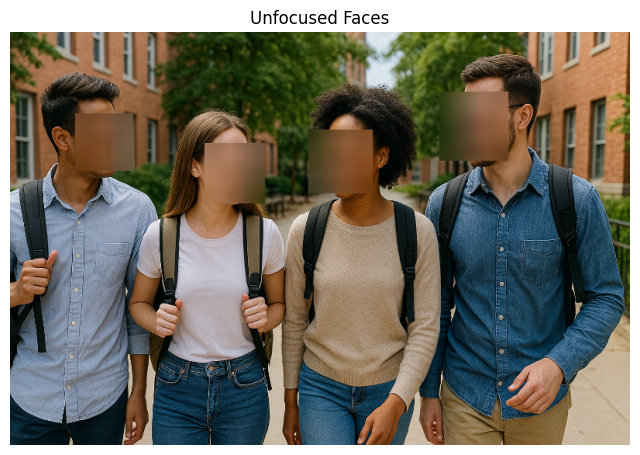

✅ Image saved in: output/detected_students.png
✅ Image saved in: output/blurred_students.png


In [ ]:
# Main execution
name_image = "students.png"  # Change to the name of your image in the 'input' folder
input_path = f"{'input'}/{name_image}"

# Detection with IDs and message if nothing is detected
image, detections = detect_faces_with_ids(input_path)
print(f"🔍 Detections found: {len(detections)}")

if detections:
    show_image(image, title="Detection with IDs")
    
    # Blur detected faces
    blurred = blur_faces(input_path)
    show_image(blurred, title="Unfocused Faces")

    # Save only if faces were detected
    while True:
        user_input = input("Do you want to save the images? (Y/N): ").strip().lower()
        if user_input in ['y', 'yes']:
            save_output(image, filename=f"detected_{name_image}")
            save_output(blurred, filename=f"blurred_{name_image}")
            break
        elif user_input in ['n', 'no']:
            print("❌ Images not saved.")
            break
        else:
            print("❓ Invalid input, please enter 'Y' or 'N'.")
        
else:
    print("⛔ Process stopped: no faces detected.")


In [ ]:
# Function to detect faces in real-time from webcam
def detect_faces_from_webcam():
    cap = cv2.VideoCapture(0)

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = detector.process(rgb)

            if results.detections:
                h, w, _ = frame.shape  # Height and width to convert relative bboxes

                for i, detection in enumerate(results.detections):
                    bbox = detection.location_data.relative_bounding_box
                    score = detection.score[0]
                    x = int(bbox.xmin * w)
                    y = int(bbox.ymin * h)

                    #print(f"[#{i+1}] Confidence: {score:.2f}, BBox: (x={bbox.xmin:.2f}, y={bbox.ymin:.2f}, w={bbox.width:.2f}, h={bbox.height:.2f})")
                    mp_drawing.draw_detection(frame, detection)

                    # Draw ID as text
                    cv2.putText(frame, f"#{i+1}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                                0.9, (0, 255, 0), 2, cv2.LINE_AA)

            cv2.imshow('Face Detection - Press ESC to exit', frame)
            if cv2.waitKey(1) & 0xFF == 27:  # ESC key to exit
                break

    cap.release()
    cv2.destroyAllWindows()

detect_faces_from_webcam()


In [ ]:
# Function to blur faces from webcam in real-time
def blurred_faces_from_webcam():
    cap = cv2.VideoCapture(0)

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = detector.process(rgb)

            if results.detections:
                h, w, _ = frame.shape  # Height and width to convert relative bboxes
                for i, detection in enumerate(results.detections):
                    bbox = detection.location_data.relative_bounding_box
                    x1 = int(bbox.xmin * w)
                    y1 = int(bbox.ymin * h)
                    x2 = int((bbox.xmin + bbox.width) * w)
                    y2 = int((bbox.ymin + bbox.height) * h)

                    face_roi = frame[y1:y2, x1:x2]
                    face_blur = cv2.GaussianBlur(face_roi, (55, 55), 30)
                    frame[y1:y2, x1:x2] = face_blur

            cv2.imshow('Blurred face - Press ESC to exit', frame)
            if cv2.waitKey(1) & 0xFF == 27:  # ESC key to exit
                break

    cap.release()
    cv2.destroyAllWindows()

blurred_faces_from_webcam()
